In [1]:
import sys

In [2]:
print(sys.executable)

/cvmfs/jupyter.hpc.rwth.de/clients/python311-c23/bin/python


In [3]:
sys.path.append('/home/bh774267/.local/lib/python3.11/site-packages')

In [8]:
!pip install --user torch torchvision

  Using cached torch-2.9.1-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (30 kB)
  Using cached filelock-3.20.0-py3-none-any.whl.metadata (2.1 kB)
  Using cached fsspec-2025.10.0-py3-none-any.whl.metadata (10 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.8.93-py3-none-manylinux2010_x86_64.manylinux_2_12_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cuda_runtime_cu12-12.8.90-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cuda_cupti_cu12-12.8.90-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cudnn_cu12-9.10.2.21-py3-none-manylinux_2_27_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_cublas_cu12-12.8.4.1-py3-none-manylinux_2_27_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cufft_cu12-11.3.3.83-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_curand_cu12-10.3.9.90-py3-none-manylinux_2_27_x86_64.whl.metadata (1.7 kB)
  Using cached nvi

In [4]:
!pip install --user Pillow

In [28]:
!pip install --user ptflops

  Using cached ptflops-0.7.5-py3-none-any.whl.metadata (9.4 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.8.93-py3-none-manylinux2010_x86_64.manylinux_2_12_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cuda_runtime_cu12-12.8.90-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cuda_cupti_cu12-12.8.90-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cudnn_cu12-9.10.2.21-py3-none-manylinux_2_27_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_cublas_cu12-12.8.4.1-py3-none-manylinux_2_27_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cufft_cu12-11.3.3.83-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_curand_cu12-10.3.9.90-py3-none-manylinux_2_27_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cusolver_cu12-11.7.3.90-py3-none-manylinux_2_27_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_cusparse_cu12-12.5.8.93-py3-none-manylinux2014_

In [4]:
import torch
import pennylane as qml

In [5]:
import matplotlib.pyplot as plt

In [6]:
import numpy as np
import pandas as pd
import os

In [7]:
import torch.nn as nn

In [8]:
import torchvision

In [9]:
import torch.nn.functional as F

In [10]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import time
from sklearn.metrics import f1_score, precision_score, recall_score
from PIL import Image
from ptflops import get_model_complexity_info

In [11]:
# Constants
I0 = 1.0  # peak intensity

# Parameters
img_width = 64           # pixels across x
img_height = 64           # vertical height for visualization
output_dir = "double_slit_images"
metadata_dir = "double_slit_metadata"
os.makedirs(output_dir, exist_ok=True)
os.makedirs(metadata_dir, exist_ok=True)
x = np.linspace(-10e-3, 10e-3, img_width)  # screen positions

# Simulation Parameters
num_samples = 50000
num_points = 512      # number of x points per pattern
#x = np.linspace(-10e-3, 10e-3, num_points)  # screen positions in meters

# Define parameter ranges
d_range = (0.2e-3, 0.8e-3)   # slit separation [m]
a_range = (0.02e-3, 0.1e-3)  # slit width [m]
λ_range = (400e-9, 700e-9)   # wavelength [m]
L_range = (1.0, 2.0)         # distance to screen [m]

In [12]:
print(0.1e-3/350e-9)

285.7142857142857


In [13]:

def double_slit_intensity(x, d, a, λ, L, I0=1.0):
    beta = (np.pi * d * x) / (λ * L)
    alpha = (np.pi * a * x) / (λ * L)
    sinc = np.sinc(alpha / np.pi)  # np.sinc uses sin(pi*x)/(pi*x)
    I = I0 * (np.cos(beta)**2) * (sinc**2)
    return I / np.max(I)  # normalize to [0, 1]

# Define the 8 thresholds for the d/λ ratio (Based on range ~143 to 2500)
# These define the boundaries between classes 0, 1, 2, ..., 7
#THRESHOLDS = [1028, 1618, 2208]
THRESHOLDS = [700, 1200, 1700]
#THRESHOLDS = [400e-9, 450e-9, 500e-9, 550e-9, 600e-9, 650e-9, 700e-9]
#THRESHOLDS = [438, 1028, 1913]
NOISE_STD_DEV = 0.1 # Standard deviation for Gaussian Noise (Recommended for robustness)

# Data generation loop
metadata = []

for i in range(num_samples):
    d = np.random.uniform(*d_range)
    a = np.random.uniform(*a_range)
    λ = np.random.uniform(*λ_range)
    L = np.random.uniform(*L_range)

    # Calculate Intensity
    I_x = double_slit_intensity(x, d, a, λ, L, I0)
    #print("Inetensity data", I_x)
    img = np.tile(I_x, (img_height, 1))

    # Add Gaussian Noise
    noise = np.random.normal(0.0, NOISE_STD_DEV, img.shape)
    noisy_img = img + noise
    img_to_save = np.clip(noisy_img, 0.0, 1.0) # Ensure values stay within [0, 1]

    # Calculate Ratio and Determine Class (The core classification logic)
    d_lambda_ratio = d / λ
   # class_label = "7" # Default to the highest class
    class_label = str(len(THRESHOLDS))
    # Assign class based on which threshold interval λ falls into
    for j, threshold in enumerate(THRESHOLDS):
        if d_lambda_ratio < threshold:
            class_label = str(j)
            break
        
    # 5. Create the class folder structure
    class_output_dir = os.path.join(output_dir, class_label)
    os.makedirs(class_output_dir, exist_ok=True)
    
    # 6. Save image into the correct class folder
    filename = f"pattern_{i:04d}.png"
    img_to_save = img_to_save.astype(np.float32)

    

    img_pil = Image.fromarray((img_to_save * 255).astype(np.uint8), mode='L') 
    
    img_pil.save(os.path.join(class_output_dir, filename))
    
    # plt.imsave(os.path.join(class_output_dir, filename), img_to_save, vmin=0, vmax=1)
    
    # 7. Append metadata (include the assigned class for verification)
    metadata.append([filename, d, a, λ, L, d_lambda_ratio, class_label])


# Save Metadata (Updated columns)
metadata_df = pd.DataFrame(metadata, columns=["filename", "d", "a", "lambda", "L", "d_lambda_ratio", "class"])
metadata_df.to_csv(os.path.join(metadata_dir, "metadata.csv"), index=False)

print(f"Generated {num_samples} patterns, distributed into 4 class folders (0-3) in '{output_dir}/'")



Generated 50000 patterns, distributed into 4 class folders (0-3) in 'double_slit_images/'


In [14]:
from PIL import Image
import numpy as np

img = Image.open("double_slit_images/0/pattern_0001.png")
print(np.array(img).shape)

(64, 64)


In [52]:
metadata_df = pd.read_csv("double_slit_metadata/metadata.csv")

# Filter rows where class == "0"
class0 = metadata_df[metadata_df["class"] == "0"]

# Now check that all wavelengths are between 400–450 nm
assert class0["lambda"].between(350e-9, 450e-9).all()

In [15]:
"""
import os
import shutil

# Folder where your images currently are
source_folder = "jupyterlab"

# Name of the subfolder to create
subfolder_name = "intensities"
target_folder = os.path.join(source_folder, subfolder_name)

# Create the subfolder if it doesn't exist
os.makedirs(target_folder, exist_ok=True)

# Move all .png files into the subfolder
for file_name in os.listdir(source_folder):
    if file_name.lower().endswith('.png'):
        full_source_path = os.path.join(source_folder, file_name)
        full_target_path = os.path.join(target_folder, file_name)

        # Make sure it's a file (not a directory)
        if os.path.isfile(full_source_path):
            shutil.move(full_source_path, full_target_path)

print(f"Moved all .png files from '{source_folder}' to '{target_folder}'")
"""

'\nimport os\nimport shutil\n\n# Folder where your images currently are\nsource_folder = "jupyterlab"\n\n# Name of the subfolder to create\nsubfolder_name = "intensities"\ntarget_folder = os.path.join(source_folder, subfolder_name)\n\n# Create the subfolder if it doesn\'t exist\nos.makedirs(target_folder, exist_ok=True)\n\n# Move all .png files into the subfolder\nfor file_name in os.listdir(source_folder):\n    if file_name.lower().endswith(\'.png\'):\n        full_source_path = os.path.join(source_folder, file_name)\n        full_target_path = os.path.join(target_folder, file_name)\n\n        # Make sure it\'s a file (not a directory)\n        if os.path.isfile(full_source_path):\n            shutil.move(full_source_path, full_target_path)\n\nprint(f"Moved all .png files from \'{source_folder}\' to \'{target_folder}\'")\n'

In [15]:
import torch
import os
from PIL import Image
from torchvision import transforms
from tqdm import tqdm

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(1),
    transforms.ToTensor()
])

root = "double_slit_images"
tensor_images = []
labels = []

folder = datasets.ImageFolder(root)

for path, label in tqdm(folder.samples):
    img = Image.open(path).convert("L")
    tensor_images.append(transform(img))
    labels.append(label)

tensor_images = torch.stack(tensor_images)
labels = torch.tensor(labels)

torch.save((tensor_images, labels), "double_slit_tensor_dataset.pt")
tensor_images, labels = torch.load("double_slit_tensor_dataset.pt")

dataset = torch.utils.data.TensorDataset(tensor_images, labels)
"""
train_val_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_val_size
#train_size = int(0.8 * len(train_val_size))
#val_size = len(train_val_size) - train_size


train_val_dataset, test_dataset = random_split(dataset, [train_val_size, test_size])

train_size = int(0.8 * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size

train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])

trainloader_split = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers = 4, pin_memory=True, persistent_workers=True)
valloader_split = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True,num_workers = 4,pin_memory=True, persistent_workers=True )
testloader_split = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)
"""

100%|██████████| 139830/139830 [01:45<00:00, 1325.61it/s]


'\ntrain_val_size = int(0.8 * len(dataset))\ntest_size = len(dataset) - train_val_size\n#train_size = int(0.8 * len(train_val_size))\n#val_size = len(train_val_size) - train_size\n\n\ntrain_val_dataset, test_dataset = random_split(dataset, [train_val_size, test_size])\n\ntrain_size = int(0.8 * len(train_val_dataset))\nval_size = len(train_val_dataset) - train_size\n\ntrain_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])\n\ntrainloader_split = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers = 4, pin_memory=True, persistent_workers=True)\nvalloader_split = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True,num_workers = 4,pin_memory=True, persistent_workers=True )\ntestloader_split = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)\n'

In [16]:
from torch.utils.data import random_split
from sklearn.model_selection import train_test_split


train_val_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_val_size
#train_size = int(0.8 * len(train_val_size))
#val_size = len(train_val_size) - train_size


train_val_dataset, test_dataset = random_split(dataset, [train_val_size, test_size])

train_size = int(0.8 * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size

train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])

trainloader_split = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers = 4, pin_memory=True, persistent_workers=True)
valloader_split = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True,num_workers = 4, pin_memory=True, persistent_workers=True )
testloader_split = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


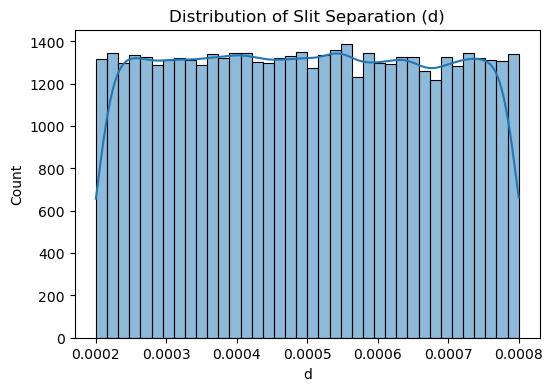

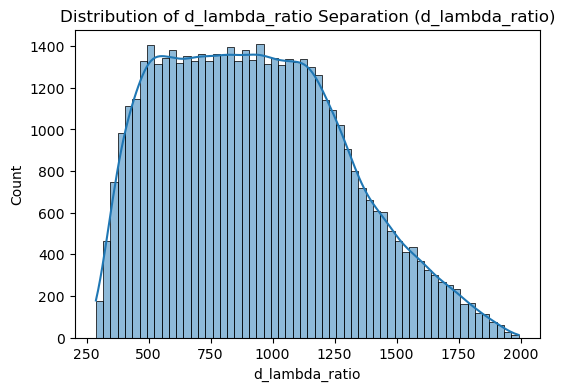

"\n# Crucial Check: Diversity of Slit Width (a) within each Wavelength Class\nplt.figure(figsize=(10, 6))\nsns.boxplot(x='class', y='I_x', data=metadata_df)\nplt.title('Slit Width (a) Distribution Across intensity ratio Classes')\nplt.ylabel('Slit Width (a) [m]')\nplt.xlabel('Wavelength Class Index')\nplt.show()\n"

In [19]:
# Assuming you have loaded your metadata_df
import seaborn as sns
import matplotlib.pyplot as plt
# metadata_df = pd.read_csv(os.path.join(metadata_dir, "metadata.csv")) 

# Check the distribution of slit separation (d) across ALL samples
plt.figure(figsize=(6, 4))
sns.histplot(metadata_df['d'], kde=True)
plt.title('Distribution of Slit Separation (d)')
plt.show()

# Check the distribution of intensity (I_x) across ALL samples
plt.figure(figsize=(6, 4))
sns.histplot(metadata_df['d_lambda_ratio'], kde=True)
plt.title('Distribution of d_lambda_ratio Separation (d_lambda_ratio)')
plt.show()

"""
# Crucial Check: Diversity of Slit Width (a) within each Wavelength Class
plt.figure(figsize=(10, 6))
sns.boxplot(x='class', y='I_x', data=metadata_df)
plt.title('Slit Width (a) Distribution Across intensity ratio Classes')
plt.ylabel('Slit Width (a) [m]')
plt.xlabel('Wavelength Class Index')
plt.show()
"""

In [20]:
data_iter = iter(trainloader_split)
images, labels = next(data_iter) 
# Check the labels here before sending to GPU
print(f"Labels dtype: {labels.dtype}") # Must be torch.int64 (Long)
print(f"Labels max value: {labels.max()}") # Must be <= 7
print(f"Labels min value: {labels.min()}")

print(labels.min().item(), labels.max().item())

/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Labels dtype: torch.int64
Labels max value: 3
Labels min value: 0
0 3


In [20]:
print(outputs.shape)  # should be [batch_size, num_classes]
print(labels.shape)  

NameError: name 'outputs' is not defined

In [17]:
print(dataset.classes)        # list of class names
print(len(dataset.classes))  

AttributeError: 'TensorDataset' object has no attribute 'classes'

In [17]:
class CNN(nn.Module):
    def __init__(self,num_classes):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        #self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)  

        self.fc1 = nn.Linear(64 * 8 * 8, 256)  
        self.fc2 = nn.Linear(256,4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  
        x = self.pool(F.relu(self.conv2(x)))  
        x = self.pool(F.relu(self.conv3(x)))  
        #x = self.pool(F.relu(self.conv4(x)))  
        
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [19]:
print(dataset.classes)
print(dataset.class_to_idx)

AttributeError: 'TensorDataset' object has no attribute 'classes'

In [22]:
features, labels = next(iter(trainloader_split))
features, labels = features.to(device), labels.to(device)
outputs = model(features)
print(outputs.shape) 

NameError: name 'device' is not defined

In [23]:
features, labels = next(iter(trainloader_split))
features, labels = features.to(device), labels.to(device)

outputs = model(features)
print("Outputs shape:", outputs.shape)   # [B, 7]
print("Labels dtype:", labels.dtype)     # should be torch.int64
print("Labels shape:", labels.shape)     # [B]
print("Labels range:", labels.min().item(), labels.max().item())


NameError: name 'device' is not defined

In [43]:
print("------Running on CPU ------")
device = torch.device("cpu")

model = CNN(num_classes=4).to(device)  # move model to CPU

features, labels = next(iter(trainloader_split))
features, labels = features.to(device), labels.to(device)

outputs = model(features)
print(outputs.shape)

------Running on CPU ------
torch.Size([64, 4])


In [44]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN(num_classes=len(dataset.classes)).to(device)

features, labels = next(iter(trainloader_split))
features, labels = features.to(device), labels.to(device)

outputs = model(features)
print(outputs.shape)  # should be [32, 7]

AttributeError: 'TensorDataset' object has no attribute 'classes'

In [25]:
print(trainloader_split)

In [22]:
def sanity_check(dataset, model, trainloader):
    """
    Verify dataset and model alignment before training.
    - Checks number of classes in dataset
    - Checks model output size
    - Checks label ranges
    """

    # 1. Dataset classes
    num_classes_dataset = len(dataset.classes)
    print(f"Dataset reports {num_classes_dataset} classes: {dataset.classes}")

    # 2. Model output size
    features, labels = next(iter(trainloader))
    features, labels = features.to(next(model.parameters()).device), labels.to(next(model.parameters()).device)
    outputs = model(features)
    num_classes_model = outputs.shape[1]
    print(f"Model outputs {num_classes_model} classes")

    # 3. Label range
    min_label, max_label = labels.min().item(), labels.max().item()
    print(f"Labels in batch range from {min_label} to {max_label}")

    # 4. Assertions
    assert num_classes_dataset == num_classes_model, \
        f"Mismatch: dataset has {num_classes_dataset} classes but model outputs {num_classes_model}"
    assert min_label >= 0 and max_label < num_classes_model, \
        f"Invalid labels: found {min_label}–{max_label}, but model only supports 0–{num_classes_model-1}"

    print("✅ Sanity check passed: dataset and model are aligned!")


In [23]:
features, labels = next(iter(trainloader_split))

print("Labels batch:", labels)
print("Label min:", labels.min().item(), "Label max:", labels.max().item())
print("Num classes in dataset:", len(dataset.classes))

Labels batch: tensor([2, 2, 2, 0, 1, 2, 0, 3, 2, 0, 2, 0, 0, 2, 3, 0, 1, 0, 3, 1, 3, 1, 1, 0,
        0, 1, 1, 0, 2, 3, 0, 2, 0, 2, 0, 2, 0, 0, 2, 1, 2, 1, 1, 2, 2, 1, 0, 1,
        2, 0, 1, 1, 0, 0, 2, 2, 1, 2, 0, 0, 2, 1, 1, 1])
Label min: 0 Label max: 3


AttributeError: 'TensorDataset' object has no attribute 'classes'

In [40]:
sanity_check(dataset, model, valloader_split)

Dataset reports 3 classes: ['0', '1', '2']
Model outputs 4 classes
Labels in batch range from 0 to 2


AssertionError: Mismatch: dataset has 3 classes but model outputs 4

In [18]:
def cnn_eval(model, criterion, dataloader, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for features, labels in dataloader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            
            # Loss
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    avg_loss = running_loss / len(dataloader)
    accuracy = correct / len(dataloader.dataset)
    precision = precision_score(all_labels, all_predictions, average='macro', zero_division=0)
    recall    = recall_score(all_labels, all_predictions, average='macro', zero_division=0)
    f1        = f1_score(all_labels, all_predictions, average='macro', zero_division=0)
    
    return avg_loss, accuracy, precision, recall, f1

In [45]:
from torch.optim.lr_scheduler import ReduceLROnPlateau


#CNN Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

model = CNN(num_classes=4).to(device)
#Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()

In [22]:
from torch.optim.lr_scheduler import ReduceLROnPlateau


#CNN Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

model = CNN(num_classes=4).to(device)
#Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
"""
trainloader_split = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers = 4)
valloader_split = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=True)
testloader_split = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)
"""

cnn_train_loss_history = []
cnn_train_acc_history = []
cnn_val_loss_history = []
cnn_val_acc_history = []
cnn_val_f1_history = [] 
cnn_epoch_time = []
loss_bench = 0
n_epochs = 50


for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    total = 0
    correct = 0
    start_time = time.time()
    
    for features, labels in trainloader_split:
        features, labels = features.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    end_time = time.time()
    
    # Training metrics
    train_loss = running_loss / len(trainloader_split)
    train_acc = correct / total
    
    # Validation step
    val_loss, val_acc, val_prec, val_rec, val_f1 = cnn_eval(
        model, criterion, valloader_split, device
    )
    
    scheduler.step(val_loss)

    # Store metrics
    cnn_train_loss_history.append(train_loss)
    cnn_train_acc_history.append(train_acc * 100)
    cnn_val_loss_history.append(val_loss)
    cnn_val_acc_history.append(val_acc * 100)
    cnn_val_f1_history.append(val_f1)
    cnn_epoch_time.append(end_time - start_time)

    print(f"Epoch {epoch+1:02d}: "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f} | "
          f"Precision: {val_prec:.4f}, Recall: {val_rec:.4f}, F1: {val_f1:.4f} | "
          f"Time: {end_time - start_time:.2f}s")

RuntimeError: DataLoader worker (pid(s) 127407, 127408, 127409, 127410) exited unexpectedly

In [26]:
inputs, _ = next(iter(trainloader_split))
input_res = tuple(inputs.shape[1:])  # drop batch dimension

macs, params = get_model_complexity_info(
    model,
    input_res,
    as_strings=True,
    print_per_layer_stat=True,
    verbose=True
)

CNN(
  1.07 M, 100.000% Params, 11.31 MMac, 98.009% MACs, 
  (conv1): Conv2d(160, 0.015% Params, 655.36 KMac, 5.681% MACs, 1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(4.64 k, 0.432% Params, 4.75 MMac, 41.188% MACs, 16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(18.5 k, 1.724% Params, 4.73 MMac, 41.046% MACs, 32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(0, 0.000% Params, 114.69 KMac, 0.994% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(1.05 M, 97.733% Params, 1.05 MMac, 9.092% MACs, in_features=4096, out_features=256, bias=True)
  (fc2): Linear(1.03 k, 0.096% Params, 1.03 KMac, 0.009% MACs, in_features=256, out_features=4, bias=True)
)


[[7918 1104    9    0]
 [1273 5696 2775    0]
 [   0  938 6696  175]
 [   0    0 1118  264]]


<Figure size 640x480 with 0 Axes>

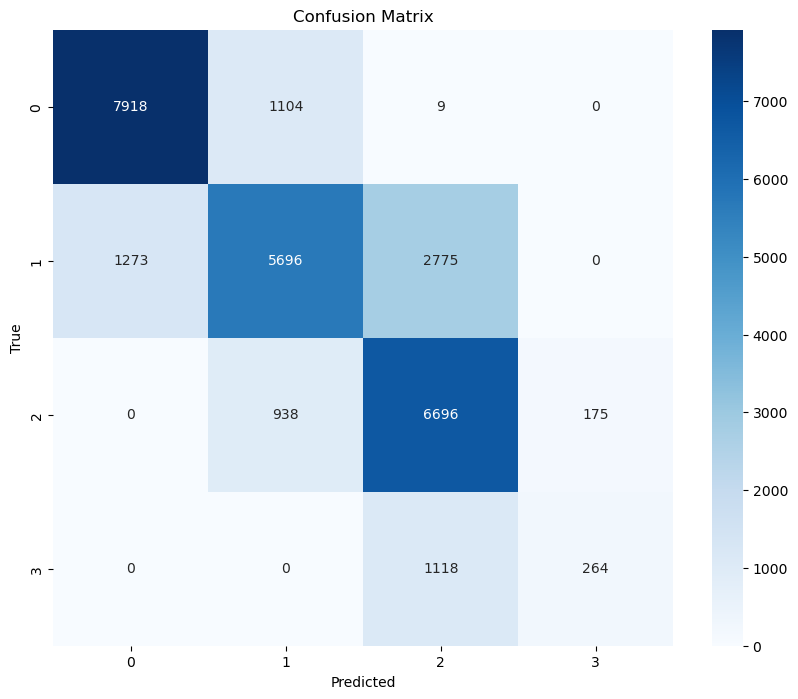

In [21]:
from sklearn.metrics import confusion_matrix

def get_predictions(model, dataloader, device):
    model.eval()
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for features, labels in dataloader:
            features, labels = features.to(device), labels.to(device)
            #reconstruction, outputs = model(features)
            outputs = model(features)
            _, predicted = torch.max(outputs, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    
    return np.array(all_labels), np.array(all_preds)

labels, preds = get_predictions(model, testloader_split, device)
cm = confusion_matrix(labels, preds)
print(cm)

import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

class_names = ["0", "1", "2", "3"]   
plt.savefig('doubleSlit_CNN_4Classes_ConfusionMatrix.png')
plot_confusion_matrix(cm, class_names)

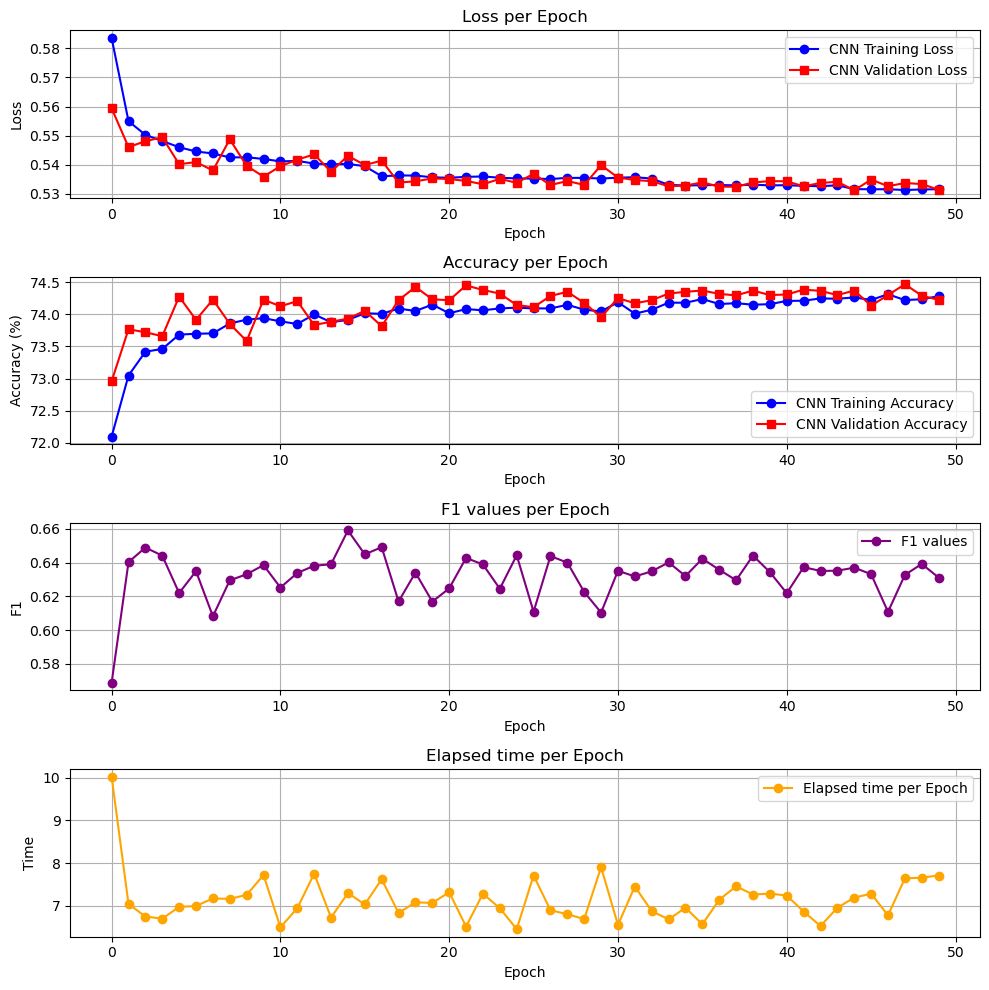

In [27]:

import matplotlib.pyplot as plt
# Plot training loss
plt.figure(figsize=(10, 10))

plt.subplot(4, 1,1)
plt.plot(cnn_train_loss_history, marker='o', label='CNN Training Loss', color='blue')
plt.plot(cnn_val_loss_history,marker='s', label='CNN Validation Loss', color='red')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Plot test accuracy
plt.subplot(4, 1, 2)
plt.plot(cnn_train_acc_history, marker= 'o', label='CNN Training Accuracy', color= 'blue')
plt.plot(cnn_val_acc_history,marker= 's', label= 'CNN Validation Accuracy', color= 'red')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()


plt.subplot(4, 1, 3)
plt.plot(cnn_val_f1_history, marker= 'o', label='F1 values', color= 'purple')
#plt.plot(test_acc_history,marker= 's', label= 'QCNN Testing Accuracy', color= 'red')
plt.title('F1 values per Epoch')
plt.xlabel('Epoch')
plt.ylabel('F1')
plt.grid(True)
plt.legend()


plt.subplot(4, 1, 4)
plt.plot(cnn_epoch_time, marker= 'o', label='Elapsed time per Epoch', color= 'orange')
#plt.plot(test_acc_history,marker= 's', label= 'QCNN Testing Accuracy', color= 'red')
plt.title('Elapsed time per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Time')
plt.grid(True)
plt.legend()


plt.tight_layout()
plt.savefig('double_slit_cnn_1Channel_50000Samples_d_lambda_Ratio_4Classes.png')
plt.show()

In [28]:
import pennylane as qml
import os
from pennylane import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from torch.func import vmap

In [48]:
#AutoEncoder Class

class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims=10):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(1*64*64, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        #print(f"Input:{x.shape}")
        x = torch.flatten(x, start_dim=1)
        #print(f"After conv1: {x.shape}")
        x = F.relu(self.linear1(x))
        #print(f"After conv2: {x.shape}")
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        #print(f"Output (Latent): {x.shape}")
        return z

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(4, 128)
        self.fc2 = nn.Linear(128, 64 * 16 * 16)
        self.deconv1 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2, padding=1)
    def forward(self, x):
        #print(f"Input (Latent): {x.shape}")
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        #print(f"After fc2: {x.shape}")
        x = x.view(-1, 64, 16, 16)
        #print(f"After view: {x.shape}")
        x = torch.relu(self.deconv1(x))
        #print(f"After deconv1: {x.shape}")
        x = torch.relu(self.deconv2(x))
        #print(f"After deconv2: {x.shape}")
        x = torch.sigmoid(self.deconv3(x))
        #print(f"Output (Reconstruction): {x.shape}")
        return x


In [49]:
dev = qml.device("default.qubit", wires=10)

In [50]:
# QCNN layer
def qcnn_block(weights,wires):
    for w in range(wires):
        qml.Hadamard(w)
    #qml.Toffoli(wires=[0,2,4])
    # Convolution Layer 1
    qml.CNOT(wires=[0, 1])
    qml.RZ(weights[0], wires=1)
    qml.CNOT(wires=[2, 3])
    qml.RZ(weights[2], wires=3)
    qml.CNOT(wires=[4, 5])
    qml.RZ(weights[4], wires=5)
    qml.CNOT(wires=[6, 7])
    qml.RZ(weights[6], wires=7)
    qml.CNOT(wires=[8, 9])
    qml.RZ(weights[8], wires=9)
    
    # Pooling Layer 1
    qml.CNOT(wires=[1, 0])
    qml.RY(weights[1], wires=0)  # keep 0, discard 1
    qml.CNOT(wires=[3, 2])
    qml.RY(weights[3], wires=2)  # keep 2, discard 3
    qml.CNOT(wires=[5, 4])
    qml.RY(weights[5], wires=4)  # keep 4, discard 5
    qml.CNOT(wires=[7, 6])
    qml.RY(weights[7], wires=6)  # keep 6, discard 7
    qml.CNOT(wires=[9, 8])
    qml.RY(weights[9], wires=8)  # keep 8, discard 9
    
    # Convolution Layer 2
    qml.CNOT(wires=[3, 1])
    qml.RZ(weights[10], wires=3)
    qml.CNOT(wires=[7, 5])
    qml.RZ(weights[12], wires=7)
    #qml.CNOT(wires=[8, 4])
    #qml.RZ(weights[14], wires=8)
    #qml.CNOT(wires=[8, 6])
    #qml.RZ(weights[16], wires=8)

     # Pooling Layer 2
    qml.CNOT(wires=[7, 3])
    qml.RY(weights[11], wires=3)  # keep 2, discard 4
    #qml.CNOT(wires=[6, 4])
    #qml.RY(weights[13], wires=2)  # keep 6, discard 3
    #qml.CNOT(wires=[8, 6])
    #qml.RY(weights[15], wires=4)  # keep 8, discard 6
    #qml.CNOT(wires=[7, 6])
    #qml.RY(weights[7], wires=6)  # keep 6, discard 7
    #qml.CNOT(wires=[9, 8])
    #qml.RY(weights[9], wires=8)  # keep 8, discard 9
    
    # Convolution Layer 3 (Final Layer)
    #qml.CNOT(wires=[2, 8])
    #qml.RY(weights[17], wires=8)
    #qml.CNOT(wires=[4, 2])
    #qml.RY(weights[5], wires=2)

In [51]:
# Full QCNN circuit

@qml.qnode(dev, interface="torch")
def quantum_circuit(inputs, weights):
    # Angle encoding
    qml.templates.AngleEmbedding(inputs, wires=range(10), rotation='Y')
    #inputs = qml.numpy.array(inputs)
    #qml.AmplitudeEmbedding(inputs, wires=range(6), normalize=True, pad_with = 0.0)
    qcnn_block(weights,wires=10)
    #print(qml.draw(qcnn_block)(weights))
    return [qml.expval(qml.PauliZ(i)) for i in [0,2,5,8]]

In [52]:
def count_ops(circuit_func, weights, wires):
    tape = qml.tape.QuantumTape()
    with tape:
        circuit_func(weights, wires)
    ops = [op.name for op in tape.operations]
    return {op: ops.count(op) for op in set(ops)}

In [53]:
def weighted_qops(counts, ent_weight=10):
    qops = 0
    for gate, num in counts.items():
        if gate in ["CNOT", "CZ", "Toffoli"]:
            qops += num * ent_weight
        else:
            qops += num
    return qops

In [54]:
weight_shapes = {"weights": (14,)}
qcnn_layer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)

class QuantumLayer(nn.Module):
    def __init__(self):
        super().__init__()
        self.qlayer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)
        nn.init.uniform_(self.qlayer.qnode_weights["weights"], -0.1, 0.1)

    def forward(self, x):
        return vmap(self.qlayer)(x)

#QCNN and AutoEncoder Hybrid Model
class HybridModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = VariationalEncoder(latent_dims=10)
        self.quantum = qcnn_layer
        self.decoder = Decoder()
        self.fc_out = nn.Linear(4, 4)  # Output logits for 4 fold classes

    
    def forward(self, x):
        latent = self.encoder(x)                      # Compress image to latent space
        #print(f"--- Hybrid Pass ---")
        #print(f"Latent Output to Quantum: {latent.shape}")
        quantum_out = self.quantum(latent)            # Quantum processing
        #print(f"Quantum Output to Decoder: {quantum_out.shape}")
        recons_image = self.decoder(quantum_out)      # reconstruction of image
        class_logits = self.fc_out(quantum_out)   # Final classification layer
        #print(f"Classifier Logits: {class_logits.shape}")                
        return recons_image, F.log_softmax(class_logits, dim=1)

In [34]:

weight_shapes = {"weights": (14,)}
#qcnn_layer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)


class QuantumLayer(nn.Module):
    def __init__(self):
        super().__init__()
        self.qlayer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)
        nn.init.uniform_(self.qlayer.qnode_weights["weights"], -0.1, 0.1)

    def forward(self, x):
        return vmap(self.qlayer)(x)
        #outputs = [self.qlayer(sample) for sample in x]
        #return torch.stack(outputs)
        """
        outputs = []
        for i, sample in enumerate(x):
            out = self.qlayer(sample)
            outputs.append(out)
        stacked = torch.stack(outputs)
        #print("  Inside QuantumLayer: input", x.shape, "output", stacked.shape)
        return stacked
        """
#QCNN Model Class
class QCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1*64*64,10) 
        self.qcnn = QuantumLayer()
        #self.qcnn = qcnn_layer
        self.fc2 = nn.Linear(in_features=4, out_features=16)
        self.fc3 = nn.Linear(16, 4)       # Output layer for 4 classes

    def forward(self, x):
        x = x.view(x.size(0), -1 )
        x = torch.tanh(self.fc1(x))
        x = self.qcnn(x) # [batch_size, 2]
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        #return F.log_softmax(x, dim=1)
        return x

In [43]:

conv_counts = count_ops(qcnn_block, weights, 4)
print("Gate counts per block:", conv_counts)
print("Weighted QOps:", weighted_qops(conv_counts))

NameError: name 'weights' is not defined

In [109]:
#train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
#test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)
"""
def evaluate(model, testloader_split, loss_fn, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for features, labels in testloader_split:
            features, labels = features.to(device), labels.to(device)
            
            outputs = model(features)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(testloader_split)
    accuracy = correct / total

    macro_precision = precision_score(all_labels, all_predictions, average='macro', zero_division=0)
    macro_recall = recall_score(all_labels, all_predictions, average='macro', zero_division=0)
    macro_f1 = f1_score(all_labels, all_predictions, average='macro', zero_division=0)
    
    return avg_loss, accuracy, macro_precision, macro_recall, macro_f1
"""

"\ndef evaluate(model, testloader_split, loss_fn, device):\n    model.eval()\n    total_loss = 0\n    correct = 0\n    total = 0\n\n    all_labels = []\n    all_predictions = []\n    \n    with torch.no_grad():\n        for features, labels in testloader_split:\n            features, labels = features.to(device), labels.to(device)\n            \n            outputs = model(features)\n            loss = loss_fn(outputs, labels)\n            total_loss += loss.item()\n\n            _, predicted = torch.max(outputs.data, 1)\n\n            all_labels.extend(labels.cpu().numpy())\n            all_predictions.extend(predicted.cpu().numpy())\n            \n            total += labels.size(0)\n            correct += (predicted == labels).sum().item()\n\n    avg_loss = total_loss / len(testloader_split)\n    accuracy = correct / total\n\n    macro_precision = precision_score(all_labels, all_predictions, average='macro', zero_division=0)\n    macro_recall = recall_score(all_labels, all_predictio

In [60]:
import torch.nn as nn
import torch.optim as optim
import time
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import precision_score, recall_score, f1_score

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = HybridModel().to(device)
#model = QCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)


# History lists for plotting
qcnnVAE_train_loss_history = []
qcnnVAE_train_acc_history = []
qcnnVAE_test_loss_history = []
qcnnVAE_test_acc_history = []
qcnnVAE_test_f1_history = [] 
qcnnVAE_epoch_time = []

#qcnn_train_loss_history = []
#qcnn_train_acc_history = []
#qcnn_test_loss_history = []
#qcnn_test_acc_history = []
#qcnn_test_f1_history = [] 
#qcnn_epoch_time = []

loss_bench = 0
n_epochs = 50

if device.type == 'cuda':
    # Reset memory stats and check before training starts
    torch.cuda.reset_peak_memory_stats(device)
    initial_memory = torch.cuda.max_memory_allocated(device)
    print(f"GPU Memory Initial State: {initial_memory / 1024**2:.2f} MB")

def qcnn_test(model, criterion,testloader_split, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for features, labels in testloader_split:
            features, labels = features.to(device), labels.to(device)
            #outputs = model(features)
            reconstruction, classification_logits = model(features)
            # Calculate and accumulate loss
            loss = criterion(classification_logits, labels)
            running_loss += loss.item()
            
            _, predicted = torch.max(classification_logits.data, 1)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            
        avg_loss = running_loss / len(testloader_split)
        accuracy = correct / len(testloader_split.dataset)
        
    # Calculate macro-averaged metrics
    # Note: Scikit-learn requires non-empty lists, which is guaranteed here
    macro_precision = precision_score(all_labels, all_predictions, average='macro', zero_division=0)
    macro_recall = recall_score(all_labels, all_predictions, average='macro', zero_division=0)
    macro_f1 = f1_score(all_labels, all_predictions, average='macro', zero_division=0)
    
    return avg_loss, accuracy, macro_precision, macro_recall, macro_f1

# --- Training Loop ---
for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    total = 0
    correct = 0
    start_time = time.time()
    
    for features, labels in trainloader_split:
        features, labels = features.to(device), labels.to(device)
        optimizer.zero_grad()
        #outputs = model(features)
        reconstruction, classification_logits = model(features)
        
        loss = criterion(classification_logits, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        _, predicted = torch.max(classification_logits.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    end_time = time.time()
    
    # Calculate Training Metrics
    train_avg_loss = running_loss / len(trainloader_split)
    train_accuracy = correct /len(trainloader_split.dataset)
    
    # Store Training History
    #qcnn_train_loss_history.append(train_avg_loss)
    qcnnVAE_train_loss_history.append(train_avg_loss)
    #qcnn_train_acc_history.append(train_accuracy*100)
    qcnnVAE_train_acc_history.append(train_accuracy*100)
    # Evaluate on Test Set
    val_loss, val_accuracy, val_precision, val_recall, val_f1 = qcnn_test(model, criterion,testloader_split, device)

    
    # Store Test History
    #qcnnVAE_test_loss_history.append(val_loss)
    #qcnnVAE_test_acc_history.append(val_accuracy*100)
    #qcnnVAE_test_f1_history.append(val_f1) # Example of tracking

    qcnnVAE_test_loss_history.append(val_loss)
    qcnnVAE_test_acc_history.append(val_accuracy*100)
    qcnnVAE_test_f1_history.append(val_f1) # Example of tracking
    
    #epoch_duration = end_time - start_time
    qcnnVAE_epoch_time.append(epoch_duration)
    #qcnn_epoch_time.append(epoch_duration)
    # Print Epoch Summary 
    print(f"Epoch {epoch+1:02d}: "
          f"Train Loss: {train_avg_loss:.4f}, Train Acc: {train_accuracy:.4f} | "
          f"Test Loss: {val_loss:.4f}, Test Acc: {val_accuracy:.4f} | "
          f"Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f} | "
          f"Time: {epoch_duration:.2f}s")
   
    if epoch == 0 and device.type == 'cuda':
        peak_memory = torch.cuda.max_memory_allocated(device)
        print(f"GPU Peak Memory Used: {(peak_memory - initial_memory) / 1024**2:.2f} MB")

GPU Memory Initial State: 143.94 MB


RuntimeError: DataLoader worker (pid(s) 87466, 87467, 87468, 87469) exited unexpectedly

[[7405 1279    3    0]
 [ 993 7019 1480    0]
 [   2 2082 5029   26]
 [   4    7 1058  160]]


<Figure size 640x480 with 0 Axes>

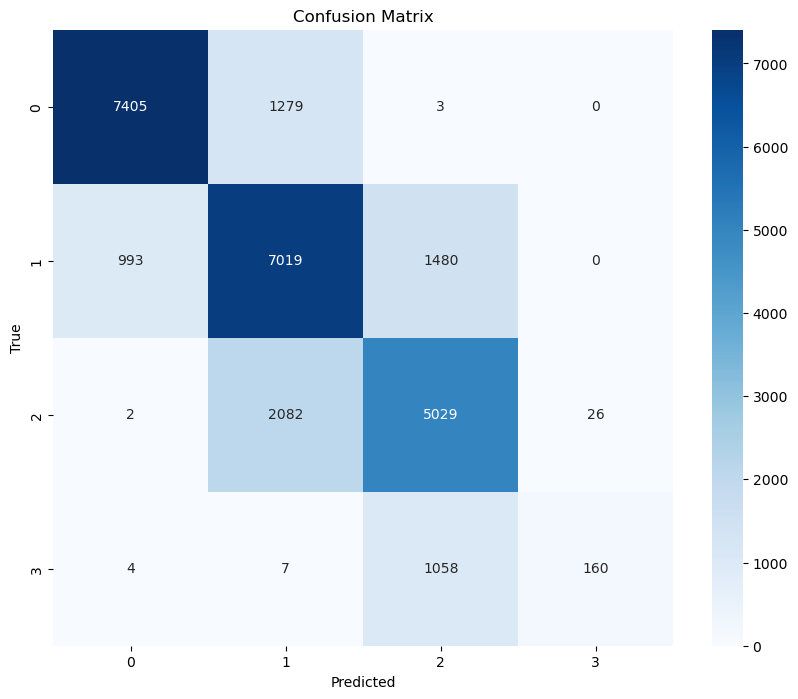

In [58]:
from sklearn.metrics import confusion_matrix

def get_predictions(model, dataloader, device):
    model.eval()
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for features, labels in dataloader:
            features, labels = features.to(device), labels.to(device)
            reconstruction, outputs = model(features)
            #outputs = model(features)
            _, predicted = torch.max(outputs, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    
    return np.array(all_labels), np.array(all_preds)

labels, preds = get_predictions(model, testloader_split, device)
cm = confusion_matrix(labels, preds)
print(cm)

import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

class_names = ["0", "1", "2", "3"]   
plt.savefig('doubleSlit_QCNNVAE_4Classes_ConfusionMatrix.png')
plot_confusion_matrix(cm, class_names)

In [22]:
import torch.nn as nn
import torch.optim as optim
import time
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import precision_score, recall_score, f1_score

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = QCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4) # weight_decay=1e-3)
#scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)


# History lists for plotting
qcnnVAE_train_loss_history = []
qcnnVAE_train_acc_history = []
qcnnVAR_test_loss_history = []
qcnnVAE_test_acc_history = []
qcnnVAE_test_f1_history = [] 
qcnnVAE_epoch_time = []

loss_bench = 0
n_epochs = 50

if device.type == 'cuda':
    # Reset memory stats and check before training starts
    torch.cuda.reset_peak_memory_stats(device)
    initial_memory = torch.cuda.max_memory_allocated(device)
    print(f"GPU Memory Initial State: {initial_memory / 1024**2:.2f} MB")

def qcnn_test(model, criterion, testloader_split, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for features, labels in testloader_split:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            #reconstruction, classification_logits = model(features)
            # Calculate and accumulate loss
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            
        avg_loss = running_loss / len(testloader_split)
        accuracy = correct / len(testloader_split.dataset)
        
    # Calculate macro-averaged metrics
    # Note: Scikit-learn requires non-empty lists, which is guaranteed here
    macro_precision = precision_score(all_labels, all_predictions, average='macro', zero_division=0)
    macro_recall = recall_score(all_labels, all_predictions, average='macro', zero_division=0)
    macro_f1 = f1_score(all_labels, all_predictions, average='macro', zero_division=0)
    
    return avg_loss, accuracy, macro_precision, macro_recall, macro_f1

# --- Training Loop ---
for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    total = 0
    correct = 0
    start_time = time.time()
    
    for features, labels in trainloader_split:
        features, labels = features.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(features)
        #reconstruction, classification_logits = model(features)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    end_time = time.time()
    
    # Calculate Training Metrics
    train_avg_loss = running_loss / len(trainloader_split)
    train_accuracy = correct /len(trainloader_split.dataset)
    
    # Store Training History
    #qcnn_train_loss_history
    qcnnVAE_train_loss_history.append(train_avg_loss)
    qcnnVAE_train_acc_history.append(train_accuracy*100)
    
    # Evaluate on Test Set
    val_loss, val_accuracy, val_precision, val_recall, val_f1 = qcnn_test(model, criterion, testloader_split, device)

    
    # Store Test History
    qcnnVAE_test_loss_history.append(val_loss)
    qcnnVAE_test_acc_history.append(val_accuracy*100)
    qcnnVAE_test_f1_history.append(val_f1) # Example of tracking
    
    
    epoch_duration = end_time - start_time
    qcnnVAE_epoch_time.append(epoch_duration)
    # Print Epoch Summary 
    print(f"Epoch {epoch+1:02d}: "
          f"Train Loss: {train_avg_loss:.4f}, Train Acc: {train_accuracy:.4f} | "
          f"Test Loss: {val_loss:.4f}, Test Acc: {val_accuracy:.4f} | "
          f"Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f} | "
          f"Time: {epoch_duration:.2f}s")
   
    if epoch == 0 and device.type == 'cuda':
        peak_memory = torch.cuda.max_memory_allocated(device)
        print(f"GPU Peak Memory Used: {(peak_memory - initial_memory) / 1024**2:.2f} MB")

GPU Memory Initial State: 0.16 MB
Epoch 01: Train Loss: 1.0139, Train Acc: 0.6904 | Test Loss: 0.8233, Test Acc: 0.7223 | Precision: 0.5413, Recall: 0.5708, F1: 0.5517 | Time: 35.78s
GPU Peak Memory Used: 96.42 MB
Epoch 02: Train Loss: 0.7345, Train Acc: 0.7296 | Test Loss: 0.6741, Test Acc: 0.7311 | Precision: 0.5484, Recall: 0.5740, F1: 0.5588 | Time: 34.44s
Epoch 03: Train Loss: 0.6441, Train Acc: 0.7346 | Test Loss: 0.6238, Test Acc: 0.7338 | Precision: 0.5555, Recall: 0.5732, F1: 0.5617 | Time: 32.66s
Epoch 04: Train Loss: 0.6092, Train Acc: 0.7364 | Test Loss: 0.5980, Test Acc: 0.7332 | Precision: 0.5526, Recall: 0.5669, F1: 0.5589 | Time: 32.43s
Epoch 05: Train Loss: 0.5891, Train Acc: 0.7372 | Test Loss: 0.5873, Test Acc: 0.7326 | Precision: 0.5495, Recall: 0.5673, F1: 0.5580 | Time: 32.70s
Epoch 06: Train Loss: 0.5765, Train Acc: 0.7381 | Test Loss: 0.5745, Test Acc: 0.7349 | Precision: 0.5536, Recall: 0.5712, F1: 0.5612 | Time: 32.77s
Epoch 07: Train Loss: 0.5653, Train Acc: 

In [39]:
from ptflops import get_model_complexity_info
inputs, _ = next(iter(trainloader_split))
input_res = tuple(inputs.shape[1:])  # drop batch dimension

macs, params = get_model_complexity_info(
    model,
    input_res,
    as_strings=True,
    print_per_layer_stat=True,
    verbose=True
)

QCNN(
  41.12 k, 99.966% Params, 41.12 KMac, 99.961% MACs, 
  (fc1): Linear(40.97 k, 99.606% Params, 40.97 KMac, 99.601% MACs, in_features=4096, out_features=10, bias=True)
  (qcnn): QuantumLayer(
    0, 0.000% Params, 0.0 Mac, 0.000% MACs, 
    (qlayer): <Quantum Torch Layer: func=quantum_circuit>
  )
  (fc2): Linear(80, 0.194% Params, 80.0 Mac, 0.194% MACs, in_features=4, out_features=16, bias=True)
  (fc3): Linear(68, 0.165% Params, 68.0 Mac, 0.165% MACs, in_features=16, out_features=4, bias=True)
)


In [44]:

sample_inputs = np.random.rand(10)       # 8 features for AngleEmbedding
sample_weights = np.random.rand(18)     # 18 parameters for your QCNN block

# Get specs
specs = qml.specs(quantum_circuit)(sample_inputs, sample_weights)

# The resources object
resources = specs["resources"]

print("Device wires:", specs["num_device_wires"])
print("Tape wires:", specs["num_tape_wires"])
print("Circuit depth:", resources.depth)

# Gate count (total operations)
gate_count = resources.num_gates
print("Gate count:", gate_count)

# Breakdown of gate types
gate_breakdown = resources.gate_types
print("Gate breakdown:", gate_breakdown)

Device wires: 10
Tape wires: 10
Circuit depth: 9
Gate count: 37
Gate breakdown: defaultdict(<class 'int'>, {'AngleEmbedding': 1, 'Hadamard': 10, 'CNOT': 13, 'RZ': 7, 'RY': 6})


In [53]:
import fvcore.nn
from fvcore.nn import FlopCountAnalysis
"""++++++++++++++
single_batch = next(iter(trainloader_split))

if isinstance(single_batch, (list, tuple)):
    input_tensor = single_batch[0]
else:
    input_tensor = single_batch

input_tensor = input_tensor.to(device)
"""
"""
all_features = []
for features_batch in trainloader_split:
    if isinstance(features_batch, (list, tuple)):
        features_batch = features_batch[0]
    all_features.append(features_batch)
    
features_tensor = torch.cat(all_features, dim=0)
#labels_tensor = torch.cat(all_labels, dim=0)
#features_tensor = features_tensor.to(device)

input_tensor = features_tensor[0:1]
input_tensor = input_tensor.to(device)

print(f"✅ Input Tensor Shape used for FLOPs: {input_tensor.shape}")
flops = FlopCountAnalysis(model, (input_tensor,))

print("\n✅ FLOPs Analysis by Module:")
print(flops.by_module())
"""

input_tensor, _ = next(iter(trainloader_split))
input_tensor = input_tensor[0:1].to(device)
#print(fvcore.nn.update_bn_stats(model, train_loader, 50))
print(fvcore.nn.parameter_count_table(model))
print(fvcore.nn.parameter_count_table(model,2))
print(fvcore.nn.flop_count_table(model, input_tensor, show_param_shapes=True))
"""
from fvcore.nn import FlopCountAnalysis
flops = FlopCountAnalysis(model, input)
flops.total()
flops.by_operator()
flops.by_module()
flops.by_module_and_operator()
"""

| name                   | #elements or shape   |
|:-----------------------|:---------------------|
| model                  | 16.5K                |
|  fc1                   |  16.4K               |
|   fc1.weight           |   (4, 4096)          |
|   fc1.bias             |   (4,)               |
|  qcnn                  |  8                   |
|   qcnn.qlayer          |   8                  |
|    qcnn.qlayer.weights |    (8,)              |
|  fc2                   |  48                  |
|   fc2.weight           |   (16, 2)            |
|   fc2.bias             |   (16,)              |
|  fc3                   |  51                  |
|   fc3.weight           |   (3, 16)            |
|   fc3.bias             |   (3,)               |
| name          | #elements or shape   |
|:--------------|:---------------------|
| model         | 16.5K                |
|  fc1          |  16.4K               |
|   fc1.weight  |   (4, 4096)          |
|   fc1.bias    |   (4,)               |
|  q

AttributeError: 'QCNN' object has no attribute '_model'

In [75]:
import torch
import fvcore.nn
from fvcore.nn import FlopCountAnalysis, parameter_count_table

# Assuming 'model' (your QCNN) and 'device' are defined.
# --- 1. Prepare Input Tensor ---
input_tensor, _ = next(iter(trainloader_split))
input_tensor = input_tensor[0:1].to(device)
print(f"✅ Input Tensor Shape: {input_tensor.shape}")

# --- 2. Parameter Count Tables (Still work fine) ---
print("\n--- Parameter Count Table ---")
# Use the function that works:
fvcore.nn.parameter_count_table(model) 

# --- 3. FLOPs Analysis (The working fix) ---

# A. Create the FlopCountAnalysis object explicitly.
# input_tensor must be a tuple: (input_tensor,)
flops_analysis = FlopCountAnalysis(model, (input_tensor,)) 

# B. Print the results using the object's methods, avoiding the failing wrapper.
print("\n--- FLOPs Analysis Results ---")

# Print Total FLOPs
print(f"Total FLOPs (MACs): {flops_analysis.total()}")

# Print FLOPs broken down by module (equivalent to flop_count_table)
print("\nFLOPs by Module (Internal Representation):")
# Note: This output is raw dictionary, not a formatted table, 
# but it provides the essential data.
print(flops_analysis.by_module())

✅ Input Tensor Shape: torch.Size([1, 3, 64, 64])

--- Parameter Count Table ---

--- FLOPs Analysis Results ---


RuntimeError: Unsupported value kind: Tensor

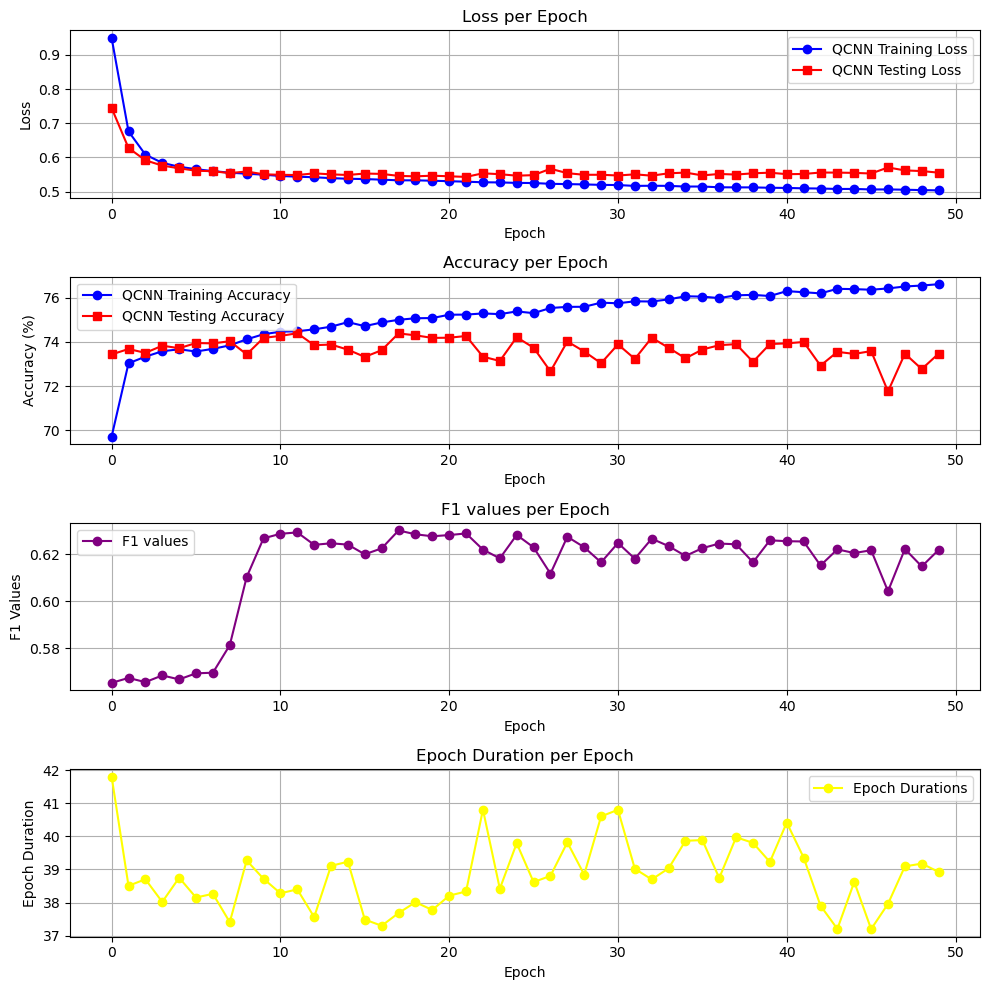

In [41]:

import matplotlib.pyplot as plt
# Plot training loss
plt.figure(figsize=(10, 10))

plt.subplot(4, 1,1)
plt.plot(qcnn_train_loss_history, marker='o', label='QCNN Training Loss', color='blue')
plt.plot(qcnn_test_loss_history,marker='s', label='QCNN Testing Loss', color='red')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

"""
qcnn_train_loss_history = []
qcnn_train_acc_history = []
qcnn_test_loss_history = []
qcnn_test_acc_history = []
qcnn_test_f1_history = [] 
qcnn_epoch_time = []
"""

# Plot test accuracy
plt.subplot(4, 1, 2)
plt.plot(qcnn_train_acc_history, marker= 'o', label='QCNN Training Accuracy', color= 'blue')
plt.plot(qcnn_test_acc_history,marker= 's', label= 'QCNN Testing Accuracy', color= 'red')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(qcnn_test_f1_history, marker= 'o', label='F1 values', color= 'purple')
#plt.plot(test_acc_history,marker= 's', label= 'QCNN Testing Accuracy', color= 'red')
plt.title('F1 values per Epoch')
plt.xlabel('Epoch')
plt.ylabel('F1 Values')
plt.grid(True)
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(qcnn_epoch_time, marker= 'o', label='Epoch Durations', color= 'yellow')
#plt.plot(test_acc_history,marker= 's', label= 'QCNN Testing Accuracy', color= 'red')
plt.title('Epoch Duration per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Epoch Duration')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig('double_slit_qcnn_10qubits_50000_4classes.png')
plt.show()

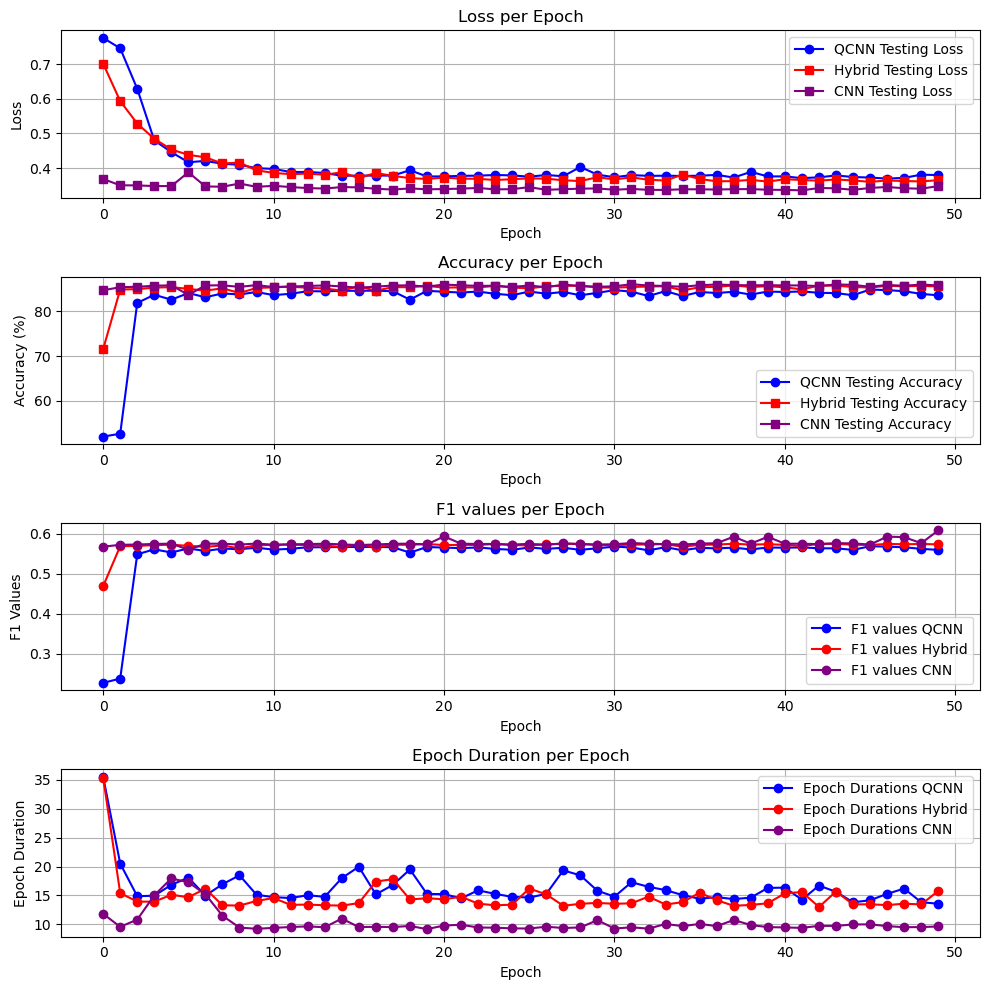

In [73]:

import matplotlib.pyplot as plt
# Plot training loss
plt.figure(figsize=(10, 10))

plt.subplot(4, 1,1)
plt.plot(qcnnVAE_train_loss_history, marker='o', label='QCNN Testing Loss', color='blue')
plt.plot(qcnnVAE_test_loss_history,marker='s', label='Hybrid Testing Loss', color='red')
#plt.plot(test_loss_history,marker='s', label='CNN Testing Loss', color='purple')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Plot test accuracy
plt.subplot(4, 1, 2)
plt.plot(qcnnVAE_train_acc_history, marker= 'o', label='QCNN Testing Accuracy', color= 'blue')
plt.plot(qcnnVAE_test_acc_history,marker= 's', label= 'Hybrid Testing Accuracy', color= 'red')
#plt.plot(test_acc_history,marker= 's', label= 'CNN Testing Accuracy', color= 'purple')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()

plt.subplot(4, 1, 3)
#plt.plot(qcnn_test_f1_history, marker= 'o', label='F1 values QCNN', color= 'blue')
plt.plot(qcnnVAE_test_f1_history, marker= 'o', label='F1 values Hybrid', color= 'red')
plt.plot(test_f1_history, marker= 'o', label='F1 values CNN', color= 'purple')
#plt.plot(test_acc_history,marker= 's', label= 'QCNN Testing Accuracy', color= 'red')
plt.title('F1 values per Epoch')
plt.xlabel('Epoch')
plt.ylabel('F1 Values')
plt.grid(True)
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(qcnn_epoch_time, marker= 'o', label='Epoch Durations QCNN', color= 'blue')
plt.plot(qcnnVAE_epoch_time, marker= 'o', label='Epoch Durations Hybrid', color= 'red')
plt.plot(cnn_epoch_time, marker= 'o', label='Epoch Durations CNN', color= 'purple')
#plt.plot(test_acc_history,marker= 's', label= 'QCNN Testing Accuracy', color= 'red')
plt.title('Epoch Duration per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Epoch Duration')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig('double_slit_cnnVSqcnnVShybrid_20000_3classes.png')
plt.show()

In [100]:
inputs, _ = next(iter(trainloader_split))
input_res = tuple(inputs.shape[1:])  # drop batch dimension

macs, params = get_model_complexity_info(
    model,
    input_res,
    as_strings=True,
    print_per_layer_stat=True,
    verbose=True
)

QCNN(
  41.13 k, 99.956% Params, 41.13 KMac, 99.961% MACs, 
  (fc1): Linear(40.97 k, 99.555% Params, 40.97 KMac, 99.560% MACs, in_features=4096, out_features=10, bias=True)
  (qcnn): QuantumLayer(
    0, 0.000% Params, 0.0 Mac, 0.000% MACs, 
    (qlayer): <Quantum Torch Layer: func=quantum_circuit>
  )
  (fc2): Linear(80, 0.194% Params, 80.0 Mac, 0.194% MACs, in_features=4, out_features=16, bias=True)
  (fc3): Linear(85, 0.207% Params, 85.0 Mac, 0.207% MACs, in_features=16, out_features=5, bias=True)
)
